### Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error,mean_squared_log_error,make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load Data

In [4]:
df=pd.read_csv('/content/Original.csv')
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (86928, 5)


,Date,Time,Temp,Humidity,Active_Power
0,1/31/2006,1:00:00 AM,11.6000,98,732.8000
1,1/31/2006,2:00:00 AM,11.6000,98,711.1000
2,1/31/2006,3:00:00 AM,21.8800,91,706.5000
3,1/31/2006,4:00:00 AM,24.4100,79,711.7000
4,1/31/2006,5:00:00 AM,25.6800,75,824.6000


### Data Prepration

In [5]:
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['Active_Power'] = pd.to_numeric(df['Active_Power'], errors='coerce')
df['Temp'] = pd.to_numeric(df['Temp'],errors='coerce')
df['Humidity'] = pd.to_numeric(df['Humidity'],errors='coerce')
df = df.dropna(subset=['Active_Power','Temp'])
df['date_time']=pd.to_datetime(df['date_time']) 
df['year'] = df['date_time'].apply(lambda x: x.year)
df['quarter'] = df['date_time'].apply(lambda x: x.quarter)
df['month'] = df['date_time'].apply(lambda x: x.month)
df['day'] = df['date_time'].apply(lambda x: x.day)
#df=df.loc[:,['date_time','Active_Power','Temp','Humidity','GDP','Population_Growth','year','quarter','month','day']]
df.sort_values('date_time', inplace=True, ascending=True)
df = df.reset_index(drop=True)
df["weekday"]=df.apply(lambda row: row["date_time"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)
print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df.date_time.min())
print('The time series ends on: ', df.date_time.max())

Number of rows and columns after removing missing values: (86928, 11)
The time series starts from:  2006-01-31 00:00:00
The time series ends on:  2015-12-31 23:00:00


### Data discribtion

In [6]:
df.describe()

,Temp,Humidity,Active_Power,year,quarter,month,day,weekday
count,86928.0000,86928.0000,86928.0000,86928.0000,86928.0000,86928.0000,86928.0000,86928.0000
mean,22.6905,82.5428,1190.8515,2010.5370,2.5069,6.5272,15.7767,0.7137
std,4.2530,12.9918,319.8326,2.8543,1.1175,3.4386,8.7502,0.4520
min,5.0000,17.0000,0.0000,2006.0000,1.0000,1.0000,1.0000,0.0000
25%,19.0700,74.0000,928.4000,2008.0000,2.0000,4.0000,8.0000,0.0000
50%,23.1400,86.0000,1172.1000,2011.0000,3.0000,7.0000,16.0000,1.0000
75%,25.9800,93.0000,1421.3000,2013.0000,4.0000,10.0000,23.0000,1.0000
max,36.4800,100.0000,2283.4000,2015.0000,4.0000,12.0000,31.0000,1.0000


In [7]:
df.shape

(86928, 11)

# Data Vizualization

### *pairplot pairwise relationships in a dataset**

 **So in this Dataset It shows that Active power has most correlation with Year,Quater,Week,day**

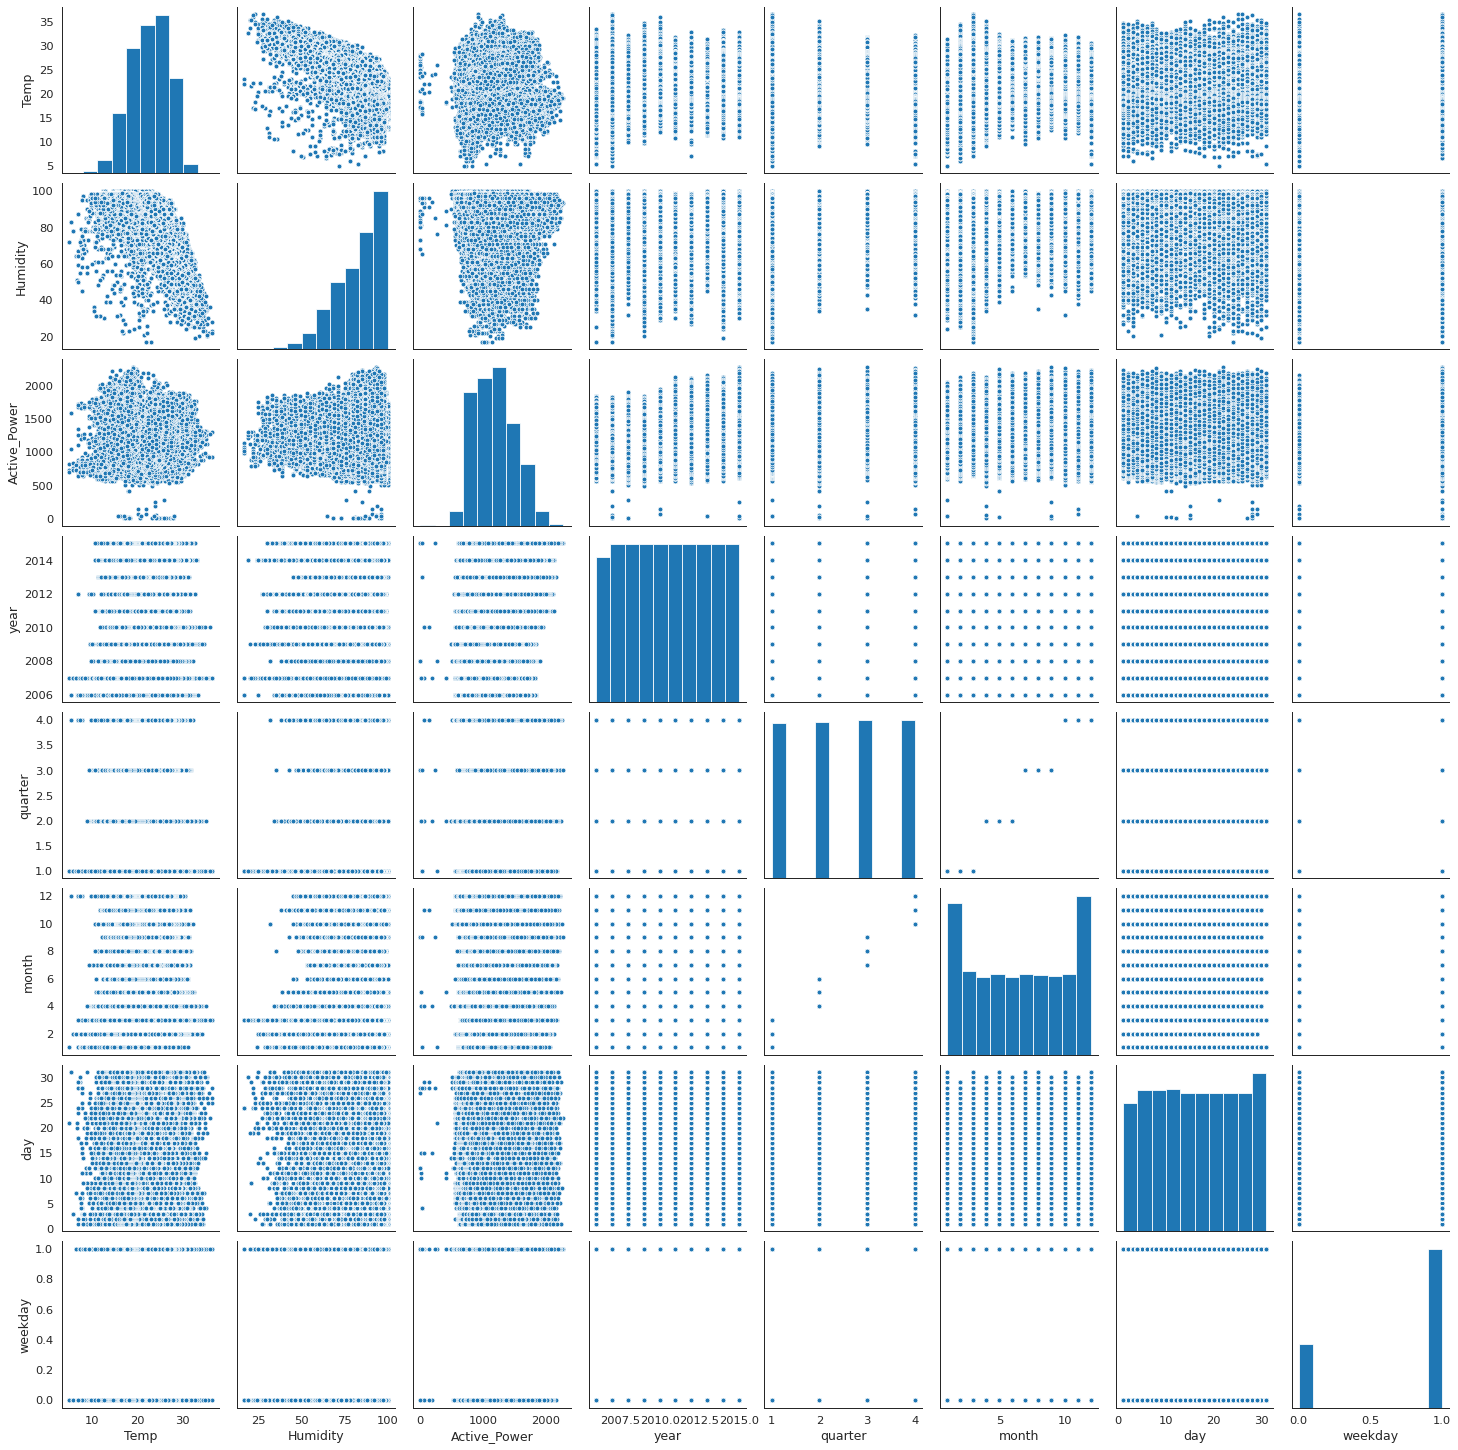

In [6]:
sns.pairplot(df)

### Distribution of Data (Displot)
### overall distribution of continuous data variables

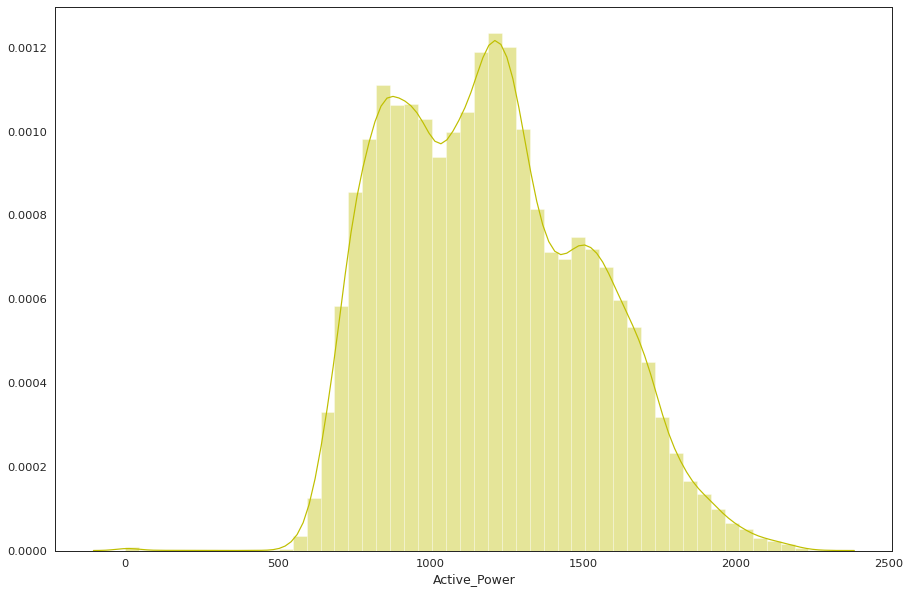

In [7]:
plt.figure(figsize=(15,10))
sns.distplot(df['Active_Power'],color="y")

### Joinplot

### displays a relationship between 2 variables 

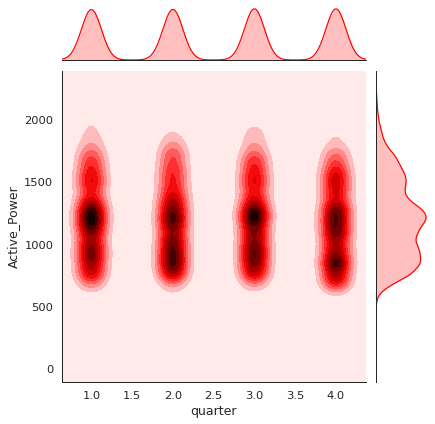

In [8]:
sns.jointplot(x="quarter",y="Active_Power",data=df,kind='kde',color='red')

In [ ]:
corr=df.corr()
corr.style.background_gradient(cmap="inferno")

,Temp,Humidity,Active_Power,year,quarter,month,day,weekday
Temp,1.000000,-0.681850,-0.091139,-0.033373,-0.025344,-0.022120,-0.004173,0.026545
Humidity,-0.681850,1.000000,-0.048703,-0.018341,0.176870,0.164105,-0.009724,0.006022
Active_Power,-0.091139,-0.048703,1.000000,0.344253,-0.034877,-0.025767,0.015226,0.125869
year,-0.033373,-0.018341,0.344253,1.000000,-0.024280,-0.027512,0.001334,0.000341
quarter,-0.025344,0.176870,-0.034877,-0.024280,1.000000,0.971333,0.026206,0.002560
month,-0.022120,0.164105,-0.025767,-0.027512,0.971333,1.000000,0.023966,0.001892
day,-0.004173,-0.009724,0.015226,0.001334,0.026206,0.023966,1.000000,-0.000408
weekday,0.026545,0.006022,0.125869,0.000341,0.002560,0.001892,-0.000408,1.000000


## Model

### Regression Evaluation Metrics¶

### Here are three common evaluation metrics for regression problems:



*   Mean Absolute Error (MAE) is the mean of the absolute value of the errors:
*   Mean Squared Error (MSE) is the mean of the squared errors:
*   Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors:

### Comparing these metrics:


1.   MAE is the easiest to understand, because it's the average error.
2.   MSE is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
3.   RMSE is even more popular than MSE, because RMSE is interpretable in the "y" units

In [8]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, x, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

### Train and Test Data

In [9]:
x=df.drop(['Date','Time','date_time','Active_Power'],axis=1) 
y=df['Active_Power']
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.1)

### 1) Linear Regression

In [10]:
lrregressor = LinearRegression()
lrregressor.fit(xtrain,ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [11]:
accuracy = lrregressor.score(xtest,ytest)
print(accuracy*100,'%')

15.831187868666918 %


### First 10 Prediction of Model

In [12]:
pred = lrregressor.predict(xtest)
pred[:10]

array([1205.30761772, 1141.79819593, 1286.47651121, 1310.1829777 ,
       1382.27588585, 1199.72581193, 1311.27320529, 1235.70576955,
       1250.13040774, 1214.44224699])

### Linear Regression Evaluation Metrics

In [13]:
results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(ytest, pred) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,245.7417,86844.0454,294.6931,0.1583,0.0195


### 2) LASSO Regression

A linear model that estimates sparse coefficients. Mathematically, it consists of a linear model trained with  ℓ1  prior as regularizer. 

In [15]:
from sklearn.linear_model import Lasso
lassomodel = Lasso()
lassomodel.fit(xtrain, ytrain)
pred = lassomodel.predict(xtest)

## LASSO Regression Evaluation Metrics

In [16]:
results_df_2 = pd.DataFrame(data=[["Lasso Regression", *evaluate(ytest, pred) , cross_val(Lasso())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,245.7417,86844.0454,294.6931,0.1583,0.0195
1,Lasso Regression,245.9619,86874.7519,294.7452,0.1580,0.0194


### 3) Light GBM Regressor

### Since the Linear and Lasso Didn't Improve the Accuarcy 
### We Used Light GBM Regressor gradient boosting framework based of decision tree algorithm 

In [19]:
mod=LGBMRegressor()
lgbmmodel=make_pipeline(mod)
lgbmmodel.fit(xtrain, ytrain)
print(model)
kfold=KFold(n_splits=5)
score=cross_val_score(model,x,y,cv=kfold)
print(score)
yp=lgbmmodel.predict(xtest)
print(yp)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
[-0.16618369  0.00936     0.0876194   0.05380964  0.06188115]
[1108.5745036  1148.04722031 1410.93322508 ... 1343.6199858  1107.44456263
 1342.44444674]


### Model Accuracy

### Increased from 16 to 34

In [20]:
accuracy = lgbmmodel.score(xtest,ytest)
print(accuracy*100,'%')

34.693017623037335 %


### LGBMRegressor Metrics

In [21]:
results_df_2 = pd.DataFrame(data=[["LGBMRegressor", *evaluate(ytest, pred) , cross_val(LGBMRegressor())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,245.7417,86844.0454,294.6931,0.1583,0.0195
1,Lasso Regression,245.9619,86874.7519,294.7452,0.1580,0.0194
2,LGBMRegressor,245.9619,86874.7519,294.7452,0.1580,0.1422


## RandomForestRegressor

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

In [22]:
mod=RandomForestRegressor(n_estimators=100)
rfrmodel=make_pipeline(mod)
print(model)
kfold=KFold(n_splits=5)
rfrmodel.fit(xtrain, ytrain)
score=cross_val_score(model,x,y,cv=kfold)
print(score)
yp=rfrmodel.predict(xtest)
print(r2_score(ytest,yp))
print(mean_squared_error(ytest,yp))

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
[-0.16618369  0.00936     0.0876194   0.05380964  0.06188115]
0.530426785710866
48449.81947404652


## Model Accuracy Increased from 34 to 51

In [25]:
accuracy = rfrmodel.score(xtest,ytest)
print(accuracy*100,'%')

53.0426785710866 %


In [24]:
results_df_2 = pd.DataFrame(data=[["RandomForestRegressor", *evaluate(ytest, pred) , cross_val(RandomForestRegressor())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,245.7417,86844.0454,294.6931,0.1583,0.0195
1,Lasso Regression,245.9619,86874.7519,294.7452,0.1580,0.0194
2,LGBMRegressor,245.9619,86874.7519,294.7452,0.1580,0.1422
3,RandomForestRegressor,245.9619,86874.7519,294.7452,0.1580,0.0550


## Single Prediction

Function That Give Prediction of all Method Applied on the dataset

In [29]:
def prediction(temp,humidity,year,quater,month,day,weekday):
  print("Linear Regression Predicition:", lrregressor.predict([[temp,humidity,year,quater,month,day,weekday]]))
  print("Lasso Regression Predicition:", lassomodel.predict([[temp,humidity,year,quater,month,day,weekday]]))
  print("LGBM Regression Predicition:", lgbmmodel.predict([[temp,humidity,year,quater,month,day,weekday]]))
  print("Random Forest Regression Predicition:", rfrmodel.predict([[temp,humidity,year,quater,month,day,weekday]]))

In [30]:
prediction(21.7800,97,2009,4,11,9,1)

Linear Regression Predicition [1106.26567593]
Lasso Regression Predicition [1106.27360222]
LGBM Regression Predicition [965.89806203]
Random Forest Regression Predicition [1006.31833333]
